<a href="https://colab.research.google.com/github/srm04072024/24240003/blob/main/Minor_Project_DDoS_attack_detect_using_LR_%26_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Install necessary libraries


In [13]:
!pip install scikit-learn pandas numpy matplotlib seaborn imblearn xgboost

# Step 2: Import Libraries

In [14]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression # Chosen for lightweight deployment [cite: 8, 62, 63]
from sklearn.tree import DecisionTreeClassifier # Chosen for lightweight deployment [cite: 8, 62, 63]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # Essential for evaluation [cite: 54]
from imblearn.over_sampling import SMOTE # Recommended for addressing class imbalance [cite: 52]


# Step 3: Load the Dataset

In [15]:
# Step 3: Load the Dataset
# Replace 'path_to_your_ton_iot_dataset.csv' with the actual path to your TON_IoT dataset.
# The TON_IoT dataset might be split into multiple files (e.g., train/test, different attack types).
# You may need to concatenate them or process them individually.
try:
    # Example: Assuming a single CSV file for simplicity. Adjust as per your TON_IoT structure.
    df = pd.read_csv('/content/TON_IoT_Train.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset not found. Please check the path and make sure it's uploaded or mounted correctly.")
    # If you are uploading directly, you'll use:
    # from google.colab import files
    # uploaded = files.upload()
    # For uploaded_file_name in uploaded.keys():
    #   df = pd.read_csv(io.BytesIO(uploaded[uploaded_file_name]))

Dataset loaded successfully.


In [16]:
df.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [17]:
df.shape

(211043, 44)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [19]:
print(df.describe())

            src_port       dst_port       duration     src_bytes  \
count  211043.000000  211043.000000  211043.000000  2.110430e+05   
mean    38646.519543    3495.153770       7.700887  2.581136e+05   
std     19307.271048   10191.624778     564.141946  1.709490e+07   
min         1.000000       0.000000       0.000000  0.000000e+00   
25%     34608.000000      65.000000       0.000000  0.000000e+00   
50%     44754.000000      80.000000       0.000170  0.000000e+00   
75%     51133.000000    1253.000000       0.054196  1.300000e+02   
max     65528.000000   65467.000000   93516.929170  3.890855e+09   

          dst_bytes  missed_bytes       src_pkts  src_ip_bytes       dst_pkts  \
count  2.110430e+05  2.110430e+05  211043.000000  2.110430e+05  211043.000000   
mean   2.588046e+05  3.443234e+04       9.595220  7.760822e+02       3.846861   
std    1.802563e+07  5.261621e+06      91.778821  2.229703e+04     330.705796   
min    0.000000e+00  0.000000e+00       0.000000  0.000000e+00 

In [20]:
print(df.columns.tolist())

['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'label', 'type']


# Step 4: Data Preprocessing

In [21]:


# Handle missing values (if any)
print("\n--- Handling Missing Values ---")
initial_rows = df.shape[0]
df.dropna(inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} rows with missing values.")

# Identify features (X) and target (y)
target_column = 'type'

# Verify target column exists
if target_column not in df.columns:
    print(f"Error: The specified target column '{target_column}' was not found in the dataset.")
    print("Please check your dataset's column names using 'df.columns' and update 'target_column'.")
    exit()

print(f"\nIdentified target column: '{target_column}'")

# Encode categorical features (excluding the target column)
print("\n--- Encoding Categorical Features ---")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != target_column:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        print(f"Encoded column: {col}")

# Encode the target variable ('type') to binary (DDoS = 1, Others = 0)
print(f"\n--- Encoding Target Column: '{target_column}' ---")
if df[target_column].dtype == 'object':
    unique_types = df[target_column].unique()
    print(f"Unique values in '{target_column}' before encoding: {unique_types}")
    df[target_column] = df[target_column].apply(lambda x: 1 if 'ddos' in str(x).lower() else 0)
    class_names_for_eval = ['Normal/Other_Attack', 'DDoS']
    class LabelEncoderDummy:
        def __init__(self, classes):
            self.classes_ = classes
    le_target = LabelEncoderDummy(class_names_for_eval)
    print(f"Encoded target column '{target_column}': 'DDoS' mapped to 1, others to 0.")
    print(f"Mapping for evaluation: {class_names_for_eval[0]} -> 0, {class_names_for_eval[1]} -> 1")

elif df[target_column].dtype in ['int64', 'float64']:
    print(f"Target column '{target_column}' is already numeric. Checking unique values.")
    unique_numeric_types = df[target_column].unique()
    print(f"Unique numeric values in '{target_column}': {unique_numeric_types}")
    if len(unique_numeric_types) > 2:
        print("Mapping non-zero numeric values to '1' (Attack) and '0' to '0' (Normal/Other).")
        df[target_column] = df[target_column].apply(lambda x: 1 if x != 0 else 0)
    elif 0 not in unique_numeric_types or 1 not in unique_numeric_types:
        print("Warning: Numeric target column has only two values but not 0/1. Assuming min value is 0, max is 1.")
        min_val = df[target_column].min()
        max_val = df[target_column].max()
        df[target_column] = df[target_column].apply(lambda x: 1 if x == max_val else 0)

    class_names_for_eval = ['Normal/Other_Attack', 'DDoS']
    class LabelEncoderDummy:
        def __init__(self, classes):
            self.classes_ = classes
    le_target = LabelEncoderDummy(class_names_for_eval)

# --- Crucial Verification Step: Check target distribution AFTER binarization ---
print(f"\nTarget distribution after binarization for '{target_column}':")
final_target_counts = df[target_column].value_counts()
print(final_target_counts)

if len(final_target_counts) != 2:
    print("\n\n#########################################################################")
    print("  ERROR: Target column still does NOT have exactly 2 unique values after binarization.")
    print("  This is the source of your 'ValueError' in classification_report.")
    print("  Please inspect 'df[target_column].unique()' and your encoding logic carefully.")
    print("  The 'type' column may contain values not caught by 'DDoS' keyword or be numeric with complex mapping.")
    print("#########################################################################\n")
    exit()

# Separate features (X) and target (y)
columns_to_drop = [target_column]
if 'label' in df.columns and 'label' != target_column:
    columns_to_drop.append('label')

X = df.drop(columns=columns_to_drop)
y = df[target_column]

# --- End of Colab Cell 4 ---


--- Handling Missing Values ---
Dropped 0 rows with missing values.

Identified target column: 'type'

--- Encoding Categorical Features ---
Encoded column: src_ip
Encoded column: dst_ip
Encoded column: proto
Encoded column: service
Encoded column: conn_state
Encoded column: dns_query
Encoded column: dns_AA
Encoded column: dns_RD
Encoded column: dns_RA
Encoded column: dns_rejected
Encoded column: ssl_version
Encoded column: ssl_cipher
Encoded column: ssl_resumed
Encoded column: ssl_established
Encoded column: ssl_subject
Encoded column: ssl_issuer
Encoded column: http_trans_depth
Encoded column: http_method
Encoded column: http_uri
Encoded column: http_version
Encoded column: http_user_agent
Encoded column: http_orig_mime_types
Encoded column: http_resp_mime_types
Encoded column: weird_name
Encoded column: weird_addl
Encoded column: weird_notice

--- Encoding Target Column: 'type' ---
Unique values in 'type' before encoding: ['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'passwo

# Step 5: Split Data, Apply SMOTE & Scaling, Train Models (REVISED)

In [22]:


import time
import sys
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # Re-import for clarity, even if already present

# Step 5: Split Data into Training and Testing Sets FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nData split into training ({len(X_train)} samples) and testing ({len(X_test)} samples) sets.")
print(f"y_train distribution before SMOTE/Scaling:\n{y_train.value_counts()}")
print(f"y_test distribution before SMOTE/Scaling:\n{y_test.value_counts()}")

# --- Apply SMOTE ONLY on the TRAINING data ---
print(f"\nOriginal training target distribution:\n{y_train.value_counts()}")
if y_train.value_counts().min() < (y_train.value_counts().max() * 0.2):
    print("Class imbalance detected in training data. Applying SMOTE...")
    smote = SMOTE(random_state=42) # Removed n_jobs=-1
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"Resampled training target distribution:\n{y_train_resampled.value_counts()}")
    X_train = X_train_resampled
    y_train = y_train_resampled
else:
    print("No significant class imbalance detected in training data, or SMOTE not applied.")

# --- Scale numerical features ONLY AFTER SPLITTING, FIT on X_train, TRANSFORM both X_train and X_test ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit only on training data
X_test_scaled = scaler.transform(X_test)     # Transform test data using the *same* scaler
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)
print("\nNumerical features scaled (StandardScaler applied to training and test sets separately).")


# Dictionary to store models, their training times, and estimated memory usage
trained_models = {}

# Step 6: Model Training and Performance Measurement

# --- Logistic Regression Model ---
print("\n--- Training Logistic Regression Model ---")
start_time = time.perf_counter()
lr_model = LogisticRegression(random_state=42, solver='liblinear', n_jobs=-1)
lr_model.fit(X_train, y_train)
end_time = time.perf_counter()
lr_training_time = end_time - start_time
lr_memory_usage = sys.getsizeof(lr_model)
print(f"Logistic Regression model trained in {lr_training_time:.4f} seconds.")
trained_models["Logistic Regression"] = {
    "model": lr_model,
    "training_time": lr_training_time,
    "memory_usage": lr_memory_usage
}

# --- Decision Tree Model ---
print("\n--- Training Decision Tree Model ---")
start_time = time.perf_counter()
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
end_time = time.perf_counter()
dt_training_time = end_time - start_time
dt_memory_usage = sys.getsizeof(dt_model)
print(f"Decision Tree model trained in {dt_training_time:.4f} seconds.")
trained_models["Decision Tree"] = {
    "model": dt_model,
    "training_time": dt_training_time,
    "memory_usage": dt_memory_usage
}

# --- XGBoost Model ---
print("\n--- Training XGBoost Model ---")
start_time = time.perf_counter()
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb_model.fit(X_train, y_train)
end_time = time.perf_counter()
xgb_training_time = end_time - start_time
xgb_memory_usage = sys.getsizeof(xgb_model)
print(f"XGBoost model trained in {xgb_training_time:.4f} seconds.")
trained_models["XGBoost"] = {
    "model": xgb_model,
    "training_time": xgb_training_time,
    "memory_usage": xgb_memory_usage
}

# --- Random Forest Model ---
print("\n--- Training Random Forest Model ---")
start_time = time.perf_counter()
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
end_time = time.perf_counter()
rf_training_time = end_time - start_time
rf_memory_usage = sys.getsizeof(rf_model)
print(f"Random Forest model trained in {rf_training_time:.4f} seconds.")
trained_models["Random Forest"] = {
    "model": rf_model,
    "training_time": rf_training_time,
    "memory_usage": rf_memory_usage
}

print("\nAll models trained.")


Data split into training (147730 samples) and testing (63313 samples) sets.
y_train distribution before SMOTE/Scaling:
type
0    133730
1     14000
Name: count, dtype: int64
y_test distribution before SMOTE/Scaling:
type
0    57313
1     6000
Name: count, dtype: int64

Original training target distribution:
type
0    133730
1     14000
Name: count, dtype: int64
Class imbalance detected in training data. Applying SMOTE...
Resampled training target distribution:
type
0    133730
1    133730
Name: count, dtype: int64

Numerical features scaled (StandardScaler applied to training and test sets separately).

--- Training Logistic Regression Model ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Logistic Regression model trained in 19.3001 seconds.

--- Training Decision Tree Model ---
Decision Tree model trained in 2.4529 seconds.

--- Training XGBoost Model ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model trained in 13.4634 seconds.

--- Training Random Forest Model ---
Random Forest model trained in 30.3028 seconds.

All models trained.


# Step-6 : Model Evaluation and Comparison Summary


--- Evaluating Logistic Regression ---
Training Time: 19.3001 seconds
Estimated Memory Usage (sys.getsizeof): 0.05 KB
Accuracy: 0.8914
Precision: 0.9399
Recall: 0.8914
F1-Score: 0.9062

Confusion Matrix:
[[50957  6356]
 [  522  5478]]


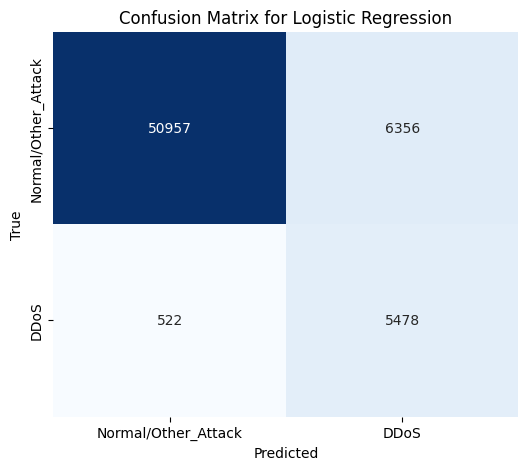


Classification Report:
                     precision    recall  f1-score   support

Normal/Other_Attack       0.99      0.89      0.94     57313
               DDoS       0.46      0.91      0.61      6000

           accuracy                           0.89     63313
          macro avg       0.73      0.90      0.78     63313
       weighted avg       0.94      0.89      0.91     63313


--- Evaluating Decision Tree ---
Training Time: 2.4529 seconds
Estimated Memory Usage (sys.getsizeof): 0.05 KB
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
F1-Score: 0.9975

Confusion Matrix:
[[57219    94]
 [   65  5935]]


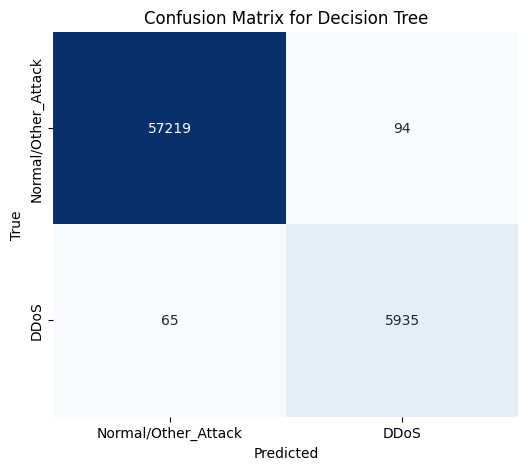


Classification Report:
                     precision    recall  f1-score   support

Normal/Other_Attack       1.00      1.00      1.00     57313
               DDoS       0.98      0.99      0.99      6000

           accuracy                           1.00     63313
          macro avg       0.99      0.99      0.99     63313
       weighted avg       1.00      1.00      1.00     63313


--- Evaluating XGBoost ---
Training Time: 13.4634 seconds
Estimated Memory Usage (sys.getsizeof): 0.05 KB
Accuracy: 0.9982
Precision: 0.9982
Recall: 0.9982
F1-Score: 0.9982

Confusion Matrix:
[[57247    66]
 [   51  5949]]


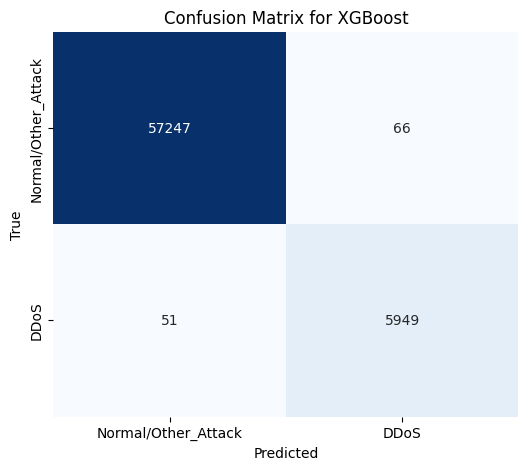


Classification Report:
                     precision    recall  f1-score   support

Normal/Other_Attack       1.00      1.00      1.00     57313
               DDoS       0.99      0.99      0.99      6000

           accuracy                           1.00     63313
          macro avg       0.99      1.00      0.99     63313
       weighted avg       1.00      1.00      1.00     63313


--- Evaluating Random Forest ---
Training Time: 30.3028 seconds
Estimated Memory Usage (sys.getsizeof): 0.05 KB
Accuracy: 0.9980
Precision: 0.9980
Recall: 0.9980
F1-Score: 0.9980

Confusion Matrix:
[[57253    60]
 [   67  5933]]


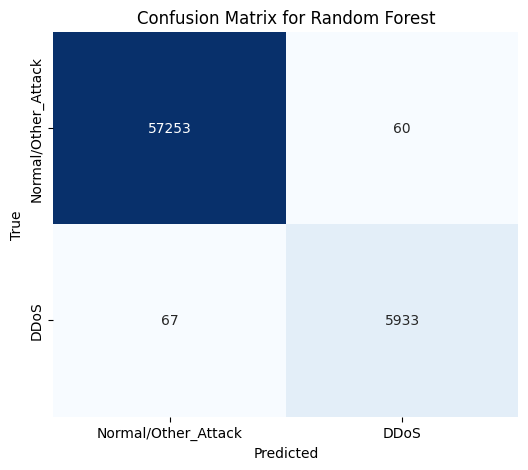


Classification Report:
                     precision    recall  f1-score   support

Normal/Other_Attack       1.00      1.00      1.00     57313
               DDoS       0.99      0.99      0.99      6000

           accuracy                           1.00     63313
          macro avg       0.99      0.99      0.99     63313
       weighted avg       1.00      1.00      1.00     63313



In [23]:


# Step 7: Model Evaluation

def evaluate_model(model, X_test, y_test, model_name, target_class_names, training_time=None, memory_usage=None):
    """Helper function to evaluate model performance and optionally display training metrics.
    Returns: A dictionary of key evaluation metrics.
    """
    print(f"\n--- Evaluating {model_name} ---")
    if training_time is not None:
        print(f"Training Time: {training_time:.4f} seconds")
    if memory_usage is not None:
        mem_kb = memory_usage / 1024
        mem_mb = mem_kb / 1024
        if mem_mb >= 1:
            print(f"Estimated Memory Usage (sys.getsizeof): {mem_mb:.2f} MB")
        else:
            print(f"Estimated Memory Usage (sys.getsizeof): {mem_kb:.2f} KB")

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_class_names,
                yticklabels=target_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_class_names, zero_division=0))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Evaluate all trained models and store their metrics
for model_name, data in trained_models.items():
    metrics = evaluate_model(data["model"], X_test, y_test, model_name, le_target.classes_,
                             training_time=data["training_time"],
                             memory_usage=data["memory_usage"])
    # Add the returned metrics to the dictionary for the summary table
    data.update(metrics)






# --- Overall Comparison Summary ---

In [24]:

print("\n" + "="*90) # Adjusted width for new columns
print(" " * 25 + "Model Comparison Summary " + " "*25)
print("="*90)
print(f"{'Model':<20} | {'Training Time (s)':<18} | {'Memory (KB)':<12} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 90) # Adjusted width for new columns

for model_name, data in trained_models.items():
    mem_kb = data["memory_usage"] / 1024
    print(f"{model_name:<20} | {data['training_time']:.4f}{'':<13} | {mem_kb:.2f}{'':<7} | {data['accuracy']:.4f}{'':<5} | {data['precision']:.4f}{'':<4} | {data['recall']:.4f}{'':<5} | {data['f1_score']:.4f}{'':<5}")

#print("\nNote on Memory Usage: `sys.getsizeof()` only accounts for the direct memory consumption of the Python object, not including underlying C-level allocations or complex data structures. Therefore, these are rough estimates for comparison purposes.")


                         Model Comparison Summary                          
Model                | Training Time (s)  | Memory (KB)  | Accuracy   | Precision  | Recall     | F1-Score  
------------------------------------------------------------------------------------------
Logistic Regression  | 19.3001              | 0.05        | 0.8914      | 0.9399     | 0.8914      | 0.9062     
Decision Tree        | 2.4529              | 0.05        | 0.9975      | 0.9975     | 0.9975      | 0.9975     
XGBoost              | 13.4634              | 0.05        | 0.9982      | 0.9982     | 0.9982      | 0.9982     
Random Forest        | 30.3028              | 0.05        | 0.9980      | 0.9980     | 0.9980      | 0.9980     


# Interpretability

In [25]:
# Step 8: Interpretability (Optional but recommended for these models)

print("\n--- Feature Importance / Coefficients (for interpretable models) ---")

# Logistic Regression Feature Importance
print("\n--- Logistic Regression Feature Importance (Coefficients) ---")
if "Logistic Regression" in trained_models and len(trained_models["Logistic Regression"]["model"].coef_[0]) == len(X.columns):
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': trained_models["Logistic Regression"]["model"].coef_[0]})
    coefficients['Absolute_Coefficient'] = np.abs(coefficients['Coefficient'])
    coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)
    print(coefficients.head(10))
else:
    print("Logistic Regression model or feature count mismatch. Cannot display feature importance.")

# Decision Tree Feature Importance
print("\n--- Decision Tree Feature Importance ---")
if "Decision Tree" in trained_models:
    dt_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': trained_models["Decision Tree"]["model"].feature_importances_})
    dt_feature_importances = dt_feature_importances.sort_values(by='Importance', ascending=False)
    print(dt_feature_importances.head(10))

# XGBoost Feature Importance
print("\n--- XGBoost Feature Importance ---")
if "XGBoost" in trained_models:
    xgb_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': trained_models["XGBoost"]["model"].feature_importances_})
    xgb_feature_importances = xgb_feature_importances.sort_values(by='Importance', ascending=False)
    print(xgb_feature_importances.head(10))

# Random Forest Feature Importance
print("\n--- Random Forest Feature Importance ---")
if "Random Forest" in trained_models:
    rf_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': trained_models["Random Forest"]["model"].feature_importances_})
    rf_feature_importances = rf_feature_importances.sort_values(by='Importance', ascending=False)
    print(rf_feature_importances.head(10))

print("\n--- End of DDoS Detection Analysis ---")
print("This code provides a comprehensive comparison framework. You may need to adjust data loading, preprocessing, and model parameters based on the specifics of your TON_IoT dataset and desired performance.")


--- Feature Importance / Coefficients (for interpretable models) ---

--- Logistic Regression Feature Importance (Coefficients) ---
         Feature  Coefficient  Absolute_Coefficient
3       dst_port    -8.039311              8.039311
22  dns_rejected     3.311820              3.311820
17     dns_qtype    -2.906233              2.906233
4          proto    -2.296258              2.296258
12  src_ip_bytes     1.661289              1.661289
14  dst_ip_bytes    -1.546470              1.546470
9     conn_state     1.297336              1.297336
32  http_version    -1.226085              1.226085
5        service    -1.098569              1.098569
41  weird_notice    -1.007558              1.007558

--- Decision Tree Feature Importance ---
         Feature  Importance
14  dst_ip_bytes    0.487119
8      dst_bytes    0.279702
9     conn_state    0.043846
11      src_pkts    0.040983
2         dst_ip    0.029518
0         src_ip    0.029342
6       duration    0.022695
15     dns_query    0